<a href="https://colab.research.google.com/github/YI-CHENG-SHIH645/ML-in-Business_practice/blob/master/Deep/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
!wget -O "utils.py" "https://github.com/YI-CHENG-SHIH645/ML-in-Business_practice/raw/master/utils.py"

# some utils written by myself
from utils import DataLoader, \
                  display_side_by_side

# visulization tools
import matplotlib.pyplot as plt
import seaborn as sns

# 3rd party libraries
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats

# ---------------- chapter specific -------------------

from tensorflow.keras import datasets,\
                             Input,\
                             Model

# ANN
from tensorflow.keras.layers import Dense

# CNN
from tensorflow.keras.layers import Conv2D, \
                                    MaxPool2D

# RNN
from tensorflow.keras.layers import SimpleRNN, \
                                    LSTM, \
                                    Bidirectional

In [3]:
#@title functions

def fetch_iowa():
    cols = ['LotArea', 'OverallQual', 'OverallCond', 'SalePrice']
    data = DataLoader.load_data('iowa_original')[cols].values
    x, y = data[:, :3], data[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

    return (x_train, x_test), (y_train, y_test)


def stdize(x_train, x_test):
    mu, sigma = x_train.mean(0), x_train.std(0)

    return (x_train - mu) / sigma, (x_test - mu) / sigma


def normal_equation(feature_matrix, target_values):
    A, b = feature_matrix, target_values

    # normal_eq
    weights = np.linalg.inv(A.T @ A) @ A.T @ b

    return weights


class SingleLayerModel(Model):
    def __init__(self):
        super(SingleLayerModel, self).__init__()
        self.d1 = Dense(3, activation='relu')
        self.d2 = Dense(1, activation='linear')

    def call(self, inputs, training=None, mask=None):
        x = self.d1(inputs)
        return self.d2(x)

    def get_config(self):
        pass


class MultiLayerModel(Model):
    def __init__(self):
        super(MultiLayerModel, self).__init__()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(64, activation='relu')
        self.d3 = Dense(1, activation='linear')

    def call(self, inputs, training=None, mask=None):
        x = self.d1(inputs)
        x = self.d2(x)
        return self.d3(x)

    def get_config(self):
        pass


def train_step(x, y, model, loss_object, optimizer):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_object(y, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss


def test_step(x, y, model, loss_object):
    y_pred = model(x)
    t_loss = loss_object(y, y_pred)

    return t_loss

# Linear Regression

不論 NN 要疊幾層 \\
先看 final layer \\
其實是我們熟悉的 Linear Regression \\
以 Linear Regression 來說，幾個 input feature \\
final layer 就有幾個 neuron (圈圈)

In [4]:
#@title 這是 linear regression 能做到最低的 mse
(x_train, x_test), (y_train, y_test) = fetch_iowa()
A_train = np.c_[x_train, np.ones(len(x_train))]
A_test = np.c_[x_test, np.ones(len(x_test))]
best_params = normal_equation(A_train, y_train)
pred = (A_train @ best_params).astype(int)

print("predictions: ", pred[:5])
print("true:        ", y_train[:5])

print(f"train mse: {mean_squared_error(y_train, pred):.2E}")
print(f"test mse: {mean_squared_error(y_test, (A_test @ best_params).astype(int)):.2E}")

predictions:  [316998 176005 263666  93151  87184]
true:         [457347 169000 221800  80000  79275]
train mse: 1.87E+09
test mse: 1.93E+09


# 看看 Neural Net 可以達到什麼樣的 mse <br>

基於 Linear Regression \\
在其前疊幾層 layer \\
關鍵在於 output 至每個 neuron 前 \\
加上 activation function \\
才能使 feature 被 "非線性地" 轉換到不同維度的空間中 \\
為了要能夠 approximate 到很複雜的 function \\
layer 多 => 能夠有效地提高複雜程度 \\
有效：同樣複雜度，單層需要更多的 neuron

In [5]:
# 使用 x_train 的 mu, std 來標準化 x_train, x_test
x_train_stdized, x_test_stdized = stdize(x_train, x_test)
train_ds = tf.data.Dataset.from_tensor_slices((x_train_stdized, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_stdized, y_test)).batch(32)

# 用以累計每個 epoch 中， minibatch 所算的 loss
train_loss = tf.keras.metrics.Sum('train_loss')
test_loss = tf.keras.metrics.Sum('test_loss')

# 使用的 loss function
loss_object = tf.keras.losses.MeanSquaredError()

# 拿到每個參數的偏微值後，以什麼方式去更新參數
optimizer = tf.keras.optimizers.Adam(learning_rate=.01)
model = MultiLayerModel()

# 記錄下每個 epoch 的 loss
train_history = []
test_history = []
for epoch in range(10):
    # 歸零累計值
    train_loss.reset_states()
    test_loss.reset_states()

    for x, y in train_ds:
        # 以 data (x, y)，loss_object 來衡量 model 目前的預測能力，
        # 得知每一個參數該往哪個方向調整會讓預測結果更精準 (auto diff)
        # 以 optimizer 決定除了方向外，要改動的值大小，且實際改動，回報改善後 loss 值
        loss = train_step(x, y, model, loss_object, optimizer)
        train_loss(loss * len(y)) # squared error
    
    for x, y in test_ds:
        t_loss = test_step(x, y, model, loss_object)
        test_loss(t_loss * len(y)) # squared error

    train_history.append(train_loss.result()/len(x_train))
    test_history.append(test_loss.result()/len(x_test))

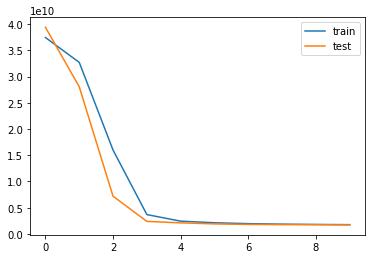

train_mse: 1.76E+09
test_mse: 1.71E+09


In [6]:
plt.plot(train_history)
plt.plot(test_history)
plt.legend(['train', 'test'])
plt.show()
print(f"train_mse: {train_history[-1]:.2E}")
print(f"test_mse: {test_history[-1]:.2E}")

In [7]:
pred = model(x_test_stdized).numpy().ravel().astype(int)
print(pred[:5])
print(y_test[:5])

[155567 219550 126259 248352 121933]
[176000 252000 135000 299800 153500]


Q：如果使用 polynomial regression，不是也能夠更進一步降低 mse 嗎？ 那它算不算非線性？ \\
節錄自 wiki： \\
    Although polynomial regression fits a nonlinear model to the data, as a statistical estimation problem it is linear, in the sense that the regression function E(y | x) is linear in the unknown parameters that are estimated from the data.

# 三個重點

*   如何計算出 output -> current predictions
*   Automatic Diffentiation(AD) -> get gradients
*   如何使用 gradients 提高模型準度 -> gradient descent methods



In [8]:
eta = 1e-3
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

tf.random.set_seed(3)
model = SingleLayerModel()

def train_step_with_details(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        loss = loss_object(y, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    print("gradients（由自動微分獲得）:")
    layer1_g = np.r_[gradients[0].numpy(), gradients[1].numpy().reshape(1, -1)]
    layer2_g = np.r_[gradients[2].numpy(), gradients[3].numpy().reshape(1, -1)]
    layer1_g_info = pd.DataFrame(layer1_g,
                                 columns=['next_neuron_1', 'next_neuron_2', 'next_neuron_3'],
                                 index=['neuron_1', 'neuron_2', 'bias'])
    layer2_g_info = pd.DataFrame(layer2_g,
                                 columns=['next_neuron_1'],
                                 index=['neuron_1', 'neuron_2', 'neuron_3', 'bias'])
    display_side_by_side([layer1_g_info, layer2_g_info], ['layer_1', 'layer_2'])
    print()
    
    layer1_init_weights = np.r_[model.weights[0].numpy(), model.weights[1].numpy().reshape(1, -1)]
    layer2_init_weights = np.r_[model.weights[2].numpy(), model.weights[3].numpy().reshape(1, -1)]
    print("original weights:")
    layer1_w_info = pd.DataFrame(layer1_init_weights,
                                 columns=['next_neuron_1', 'next_neuron_2', 'next_neuron_3'],
                                 index=['neuron_1', 'neuron_2', 'bias'])
    layer2_w_info = pd.DataFrame(layer2_init_weights,
                                 columns=['next_neuron_1'],
                                 index=['neuron_1', 'neuron_2', 'neuron_3', 'bias'])
    display_side_by_side([layer1_w_info, layer2_w_info], ['layer_1', 'layer_2'])
    print()

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    print("modified weights:")
    layer1_modified_w = np.r_[model.weights[0].numpy(), model.weights[1].numpy().reshape(1, -1)]
    layer2_modified_w = np.r_[model.weights[2].numpy(), model.weights[3].numpy().reshape(1, -1)]
    layer1_w_info = pd.DataFrame(layer1_modified_w,
                                 columns=['next_neuron_1', 'next_neuron_2', 'next_neuron_3'],
                                 index=['neuron_1', 'neuron_2', 'bias'])
    layer2_w_info = pd.DataFrame(layer2_modified_w,
                                 columns=['next_neuron_1'],
                                 index=['neuron_1', 'neuron_2', 'neuron_3', 'bias'])
    display_side_by_side([layer1_w_info, layer2_w_info], ['layer_1', 'layer_2'])
    print()

    print("layer 1 all close? ", np.allclose(layer1_modified_w, layer1_init_weights - eta * layer1_g))
    print("layer 2 all close? ", np.allclose(layer2_modified_w, layer2_init_weights - eta * layer2_g))
    print()

    print("original output:\n", y_pred, '\n')
    print("improved output:\n", model(x), '\n')
    print("y true", y, '\n')

    return layer1_init_weights, layer2_init_weights, y_pred

train_ds = tf.data.Dataset.from_tensor_slices((x_train_stdized[:, :2], y_train)).shuffle(10000).batch(1)
first_data = list(train_ds.take(1))[0]
first_data_x = first_data[0].numpy()
first_data_y = first_data[1].numpy()
print("input:")
display(pd.DataFrame(first_data_x, columns=['LotArea', 'OverallQual'], index=['first_data']))
print('\n')
layer1_init_weights, layer2_init_weights, y_pred = \
            train_step_with_details(first_data_x, first_data_y)

input:


,LotArea,OverallQual
first_data,-0.658986,-0.037847




gradients（由自動微分獲得）:


layer_1 layer_2 
 
 
 
 next_neuron_1 
 next_neuron_2 
 next_neuron_3 
 
 
 
 
 neuron_1 
 -54965.714844 
 107952.226562 
 -185454.359375 
 
 
 neuron_2 
 -3156.783691 
 6199.897949 
 -10650.990234 
 
 
 bias 
 83409.492188 
 -163815.578125 
 281423.687500 
 
 
 
 
 
 
 next_neuron_1 
 
 
 
 
 neuron_1 
 -108401.539062 
 
 
 neuron_2 
 -103700.203125 
 
 
 neuron_3 
 -120348.179688 
 
 
 bias 
 -232000.968750


original weights:


layer_1 layer_2 
 
 
 
 next_neuron_1 
 next_neuron_2 
 next_neuron_3 
 
 
 
 
 neuron_1 
 -0.669160 
 -0.687322 
 -0.823749 
 
 
 neuron_2 
 -0.694353 
 0.157313 
 0.636755 
 
 
 bias 
 0.000000 
 0.000000 
 0.000000 
 
 
 
 
 
 
 next_neuron_1 
 
 
 
 
 neuron_1 
 -0.359522 
 
 
 neuron_2 
 0.706099 
 
 
 neuron_3 
 -1.213028 
 
 
 bias 
 0.000000


modified weights:


layer_1 layer_2 
 
 
 
 next_neuron_1 
 next_neuron_2 
 next_neuron_3 
 
 
 
 
 neuron_1 
 54.296558 
 -108.639557 
 184.630615 
 
 
 neuron_2 
 2.462431 
 -6.042585 
 11.287745 
 
 
 bias 
 -83.409492 
 163.815582 
 -281.423706 
 
 
 
 
 
 
 next_neuron_1 
 
 
 
 
 neuron_1 
 108.042023 
 
 
 neuron_2 
 104.406303 
 
 
 neuron_3 
 119.135155 
 
 
 bias 
 232.000977


layer 1 all close?  True
layer 2 all close?  True

original output:
 tf.Tensor([[-0.48161826]], shape=(1, 1), dtype=float32) 

improved output:
 tf.Tensor([[24833.91]], shape=(1, 1), dtype=float32) 

y true [116000] 



## output -> current predictions

In [9]:
# activation functions
def linear(raw_output):
    return raw_output

def relu(raw_output):
    return (abs(raw_output) + raw_output) / 2

In [10]:
layers = [
    {'weights': layer1_init_weights, 'activation': relu},
    {'weights': layer2_init_weights, 'activation': linear}
]

first_data = np.c_[first_data_x, 1]
# 第一層 neuron 值為 input 資料的值
neuron_values = first_data

# run thru each layer
for i, layer in enumerate(layers):
    neuron_values = layer['activation'](neuron_values @ layer['weights'])
    if i != len(layers)-1:
        neuron_values = np.c_[neuron_values, np.ones(first_data.shape[0])]
pd.DataFrame(np.c_[neuron_values, y_pred],
             columns=['模型參數未更新前預測第一筆資料（manually cal）', '模型參數未更新前預測第一筆資料 (lib)'],
             index=['output'])

,模型參數未更新前預測第一筆資料（manually cal）,模型參數未更新前預測第一筆資料 (lib)
output,-0.481618,-0.481618


# Gradient Descent methods

## challenges:


*   Choose proper lr at each stage (loss 變化程度) -----> learning rate scheduling
*   Choose proper lr for each feature -----> adaptive learning rate
    * larger update for rarely ocurring features
    * ？ gradient 越大 -> learning rate 應該越大 ？
*   Escape from local minimum / saddle point

## Compute gradients with
*   the whole dataset
*   a single instance
*   a mini-batch

## Momentum 
reduce oscillation，dramatically accelerate training process \\
>$v_t = momentum * v_{t-1} + \eta * \nabla L(\theta_{t-1}), momentum = 0.9$ \\
>$\theta_t = \theta_{t-1} - v_t$ \\

batch size 很小， gradient方向頻繁變動， \\
減少與過往反方向的 gradient 大小 \\
在快速來回震盪的維度上，會互相抵銷 \\
增加與過往同方向的 gradient 大小， \\
在方向一致的維度上，會加速前進

In [11]:
# 一般情況 x 應該是個模型預測值，只是這邊就先當直接給出預測值，並藉由修改預測值來降低 loss（y）
def GD(x, epoch=100, my_opt=None, optimizer=None):
    history = []
    for n in range(epoch):
        with tf.GradientTape() as tape:
            y = x**2
        g = tape.gradient(y, x)

        # 自行實作的 opt
        if my_opt is not None:
            x = my_opt.step(g, x)
        # 使用 lib 的 opt
        else:
            optimizer.apply_gradients(zip([g], [x]))
            
        history.append((x**2).numpy())
    return history

In [12]:
class Momentum():
    def __init__(self, mom=0.9, eta=0.01):
        self.mt = 0
        self.mom = mom
        self.eta = eta
    
    def step(self, gradients, variables):
        self.mt = self.mom * self.mt + self.eta * gradients
        return tf.Variable(variables - self.mt)

True
True


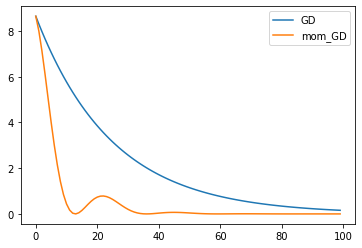

In [13]:
x = 3.0
GD_history = GD(tf.Variable(x), my_opt=Momentum(mom=0.0))
mom_GD_history = GD(tf.Variable(x), my_opt=Momentum(mom=0.9))
tf_GD_history = GD(tf.Variable(x), optimizer=tf.optimizers.SGD(momentum=0.0))
tf_mom_GD_history = GD(tf.Variable(x), optimizer=tf.optimizers.SGD(momentum=0.9))

print(np.allclose(tf_GD_history, GD_history))
print(np.allclose(mom_GD_history, tf_mom_GD_history))

plt.plot(GD_history)
plt.plot(mom_GD_history)
plt.legend(['GD', 'mom_GD'])
plt.show()

## Adagrad 

>$ \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + \epsilon}}\nabla L$ \\
>$ \epsilon = diag(1e-8),$ \\
>$ G^t $ is a k by k diagonal matrix, k = # of params \\
>$ G^{t-1}_{ii} = \sum_{j=0}^{t-1} (\nabla L(\theta^j_{i}))^2 $ \\
<br>
>問題： 隨著 $ G_t $ 累加，learning rate 降的速度會太快

## RMSprop

>$ g_t^2 = (\nabla L(\theta_t))^2 $ \\
>$ \theta_t = \theta_{t-1} - \frac{\eta}{\sqrt{G_{t-1} + \epsilon}}\nabla L$ \\
>$ G_{t-1} = 0.9 G_{t-2} + 0.1 g_{t-1}^2 $ \\
<br>
>解決 Adagrad 的問題

In [14]:
class Adagrad():
    def __init__(self, eta=0.01):
        self.cumu_g2 = 0.1
        self.eta = eta
        self.epsilon = 1e-7
        self.lr_history = []
    
    def step(self, gradients, variables):
        self.cumu_g2 += gradients**2
        lr = self.eta/tf.math.sqrt(self.cumu_g2+self.epsilon)
        self.lr_history.append(lr)
        return tf.Variable(variables - lr * gradients)

class RMSprop():
    def __init__(self, eta=0.01, mom=0.0):
        self.mt = 0
        self.mom = mom
        self.cumu_g2 = 0.0
        self.eta = eta
        self.epsilon = 1e-7
        self.lr_history = []
    
    def step(self, gradients, variables):
        self.cumu_g2 = (0.9 * self.cumu_g2 + 0.1 * gradients**2)
        lr = self.eta/tf.math.sqrt(self.cumu_g2+self.epsilon)
        self.lr_history.append(lr)
        self.mt = self.mom * self.mt + lr * gradients
        return tf.Variable(variables - self.mt)

True
True
True


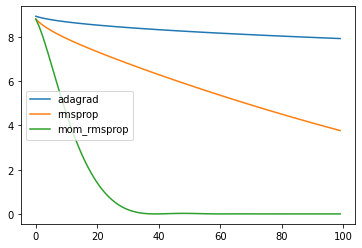

In [15]:
my_adagrad_opt = Adagrad(eta=0.01)
adagrad_history = GD(tf.Variable(x), my_opt=my_adagrad_opt)
tf_adagrad_history = GD(tf.Variable(x), optimizer=tf.optimizers.Adagrad(learning_rate=0.01))
my_rmsprop_opt = RMSprop(eta=0.01)
rmsprop_history = GD(tf.Variable(x), my_opt=my_rmsprop_opt)
tf_rmsprop_history = GD(tf.Variable(x), optimizer=tf.optimizers.RMSprop(learning_rate=0.01))
rmsprop_mom_history = GD(tf.Variable(x), my_opt=RMSprop(eta=0.01, mom=0.9))
tf_rmsprop_mom_history = GD(tf.Variable(x), optimizer=tf.optimizers.RMSprop(learning_rate=0.01, momentum=0.9))

print(np.allclose(adagrad_history, tf_adagrad_history))
print(np.allclose(rmsprop_history, tf_rmsprop_history))
print(np.allclose(rmsprop_mom_history, tf_rmsprop_mom_history))

plt.plot(adagrad_history)
plt.plot(rmsprop_history)
plt.plot(tf_rmsprop_mom_history)
plt.legend(['adagrad', 'rmsprop', 'mom_rmsprop'])
plt.show()

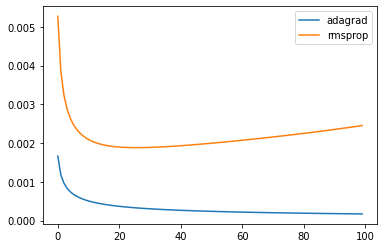

In [16]:
plt.plot(my_adagrad_opt.lr_history)
plt.plot(my_rmsprop_opt.lr_history)
plt.legend(['adagrad', 'rmsprop'])
plt.show()

# Weighted Exponential Average

$\bar{X}_{T} $
>$ = \frac{T-1}{T}\bar{X}_{T-1} + \frac{1}{T}X_T $ \\
<br>
>$ = (1 - \frac{1}{T})\bar{X}_{T-1} + \frac{1}{T}X_T $ \\
<br>
>$ = (1 - \alpha)\bar{X}_{T-1} + \alpha X_T $ \\
<br>
>$ \beta = 1 - \alpha $ \\
<br>
>$ = \beta\bar{X}_{T-1} + (1 - \beta) X_T $ \\
<br>
>$ = 0.999 \bar{X}_{T-1} + 0.001 X_T $ \\
<br>

bias correction first few weights:
9.000 1.000
2.198 0.244
1.469 0.163
1.207 0.134
1.080 0.120
1.011 0.112
0.970 0.108
0.944 0.105


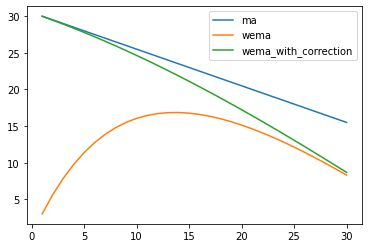

In [17]:
x = list(range(30, 0, -1))
mu_t_history = []

def mv_avg(beta, with_bias_correction=False):
    mu_t = 0
    t = 0
    mu_t_history = []
    if with_bias_correction:
        print('bias correction first few weights:')
    for i, x_t in enumerate(x):
        t += 1
        mu_t = beta(t) * mu_t + (1 - beta(t)) * x_t
        if with_bias_correction:
            mu_t_history.append(mu_t / (1 - beta(t)**t))
            if i % 4 == 0:
                print(f"{beta(t) / (1 - beta(t)**t):.3f}", end=' ')
                print(f"{(1 - beta(t)) / (1 - beta(t)**t):.3f}")
        else:
            mu_t_history.append(mu_t)
    return mu_t_history

plt.plot(range(1, 31), mv_avg(lambda t: 1 - 1/t))
plt.plot(range(1, 31), mv_avg(lambda t: 0.9))
plt.plot(range(1, 31), mv_avg(lambda t: 0.9, with_bias_correction=True))
plt.legend(['ma', 'wema', 'wema_with_correction'])
plt.show()

## Adam

>$ m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t $   ------ momentum \\
>$ v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 $ ------ RMSprop \\
>$ \hat{m_t} = \frac{m_t}{1 - \beta_1^t} $, 
>$ \hat{v_t} = \frac{v_t}{1 - \beta_2^t} $  ------ bias correction \\
<br>
$\beta_1 = 0.9, \beta_2 = 0.999$  \\
<br>
>$ \theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v_t}} + \epsilon} \hat{m_t} $

In [18]:
class Adam():
    def __init__(self, eta=0.01):
        self.eta = eta
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.mt = 0
        self.vt = 0
        self.t = 0
        self.epsilon = 1e-07
    
    def step(self, gradients, variables):
        self.t += 1
        self.mt = self.beta1 * self.mt + (1-self.beta1) * gradients
        mt_hat = self.mt / (1 - self.beta1**self.t)
        self.vt = self.beta2 * self.vt + (1-self.beta2) * gradients**2
        vt_hat = self.vt / (1 - self.beta2**self.t)
        g = self.eta * mt_hat/(tf.math.sqrt(vt_hat) + self.epsilon)
        return tf.Variable(variables - g)

True


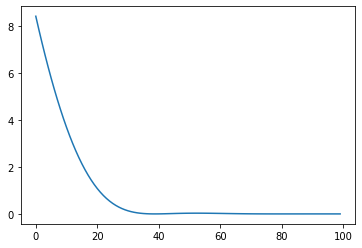

In [19]:
x = 3.0
adam_history = GD(tf.Variable(x), my_opt=Adam(eta=0.1))
tf_adam_history = GD(tf.Variable(x), optimizer=tf.optimizers.Adam(learning_rate=0.1))

print(np.allclose(adam_history, tf_adam_history, atol=1e-5))

plt.plot(adam_history)
plt.show()

# 用 NN approx. BSM model

In [20]:
n = 60000
np.random.seed(3)

N_ = stats.norm(loc=0.0, scale=1.0)
N = lambda d: N_.cdf(d)

# 依序為 stock price, strike price (times), risk free rate
#       volatility, time to maturity(year)
bounds = [(40, 60), (0.5, 1.5), (0, 0.05), (0.1, 0.4), (0.25, 2)]
S, K, r, sigma, T = [np.random.uniform(*bound, (n, 1)).round(3) for bound in bounds]
K = S * K

d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * np.sqrt(T))
d2 = (np.log(S/K) + (r - sigma**2/2)*T)/(sigma * np.sqrt(T))

option_price = S * N(d1) - K * np.exp(-r*T) * N(d2)
option_price_with_noise = option_price + np.random.normal(0.0, .15, (n, 1))

In [21]:
x = np.c_[S, K, r, sigma, T]
y = option_price_with_noise
x_train, x_r, y_train, y_r =  train_test_split(x, y, train_size=1/3, random_state=3)
x_val, x_test, y_val, y_test =  train_test_split(x_r, y_r, test_size=1/2, random_state=3)

x_train_stdized, x_val_stdized = stdize(x_train, x_val)
_, x_test_stdized = stdize(x_train, x_test)

train_ds = tf.data.Dataset.from_tensor_slices((x_train_stdized, y_train)).shuffle(10000).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val_stdized, y_val)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_stdized, y_test)).batch(32)

In [22]:
model = MultiLayerModel()
model.compile(optimizer='Adam', loss='mae')

# callbacks
es = tf.keras.callbacks.EarlyStopping('val_loss', patience=15)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=60,
                    callbacks=[es, reduce_lr],
                    verbose=0)

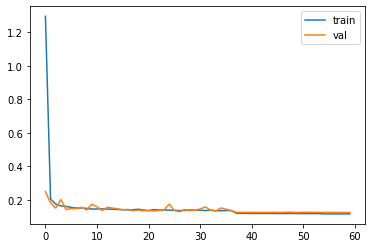

train_mse: 0.1157
val_mse: 0.1244


In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.show()
print(f"train_mse: {history.history['loss'][-1]:.4f}")
print(f"val_mse: {history.history['val_loss'][-1]:.4f}")

$f(x) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{x^2}{2 \sigma^2}}$ \\
<br>
$E[|X|]$ \\
> $ = \frac{1}{\sigma \sqrt{2\pi}} (\int_{-\infty}^0 -x e^{-\frac{x^2}{2 \sigma^2}} dx + \int_0^{\infty}x e^{-\frac{x^2}{2 \sigma^2}} dx $) \\
<br>
> let $t = \frac{x}{\sqrt2\sigma}, dt = \frac{1}{\sqrt2\sigma} dx$ \\
<br>
> $ = \frac{1}{\sqrt{\pi}} (\int_{-\infty}^0 -\sqrt2\sigma t e^{-t^2} dt + \int_0^{\infty} \sqrt2\sigma t e^{-t^2} dt)$ (上下限不動) \\
<br>$f(t) = t e^{-t^2}$ 為奇函數 \\
<br>
> $ = \sqrt{\frac{2}{\pi}}\sigma * 2 \int_0^{\infty} t e^{-t^2} dt$ \\
<br>
> let $u = -t^2, du = -2tdt, -\frac{1}{2}du = tdt$ \\
<br>
> $ = \sqrt{\frac{2}{\pi}}\sigma * (- \int_0^{-\infty} e^u du))$ \\
<br>
> $ = \sqrt{\frac{2}{\pi}}\sigma $

In [24]:
round(np.sqrt(2/np.pi) * 0.15, 4)

0.1197

# Autoencoder

In [25]:
df = DataLoader.load_data('country_risk_url')
df.head()
data = df[['Corruption', 'Peace', 'Legal', 'GDP Growth']].values
stdized_data, _ = stdize(data, data)

In [26]:
inputs = tf.keras.Input(shape=data.shape[1])
x = Dense(2, activation='relu', use_bias=False)(inputs)
outputs = Dense(data.shape[1], use_bias=False)(x)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 8         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


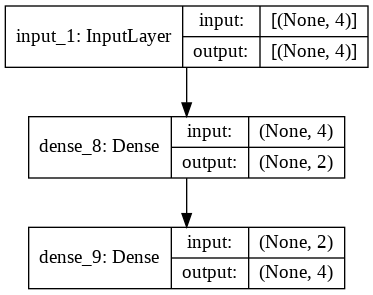

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

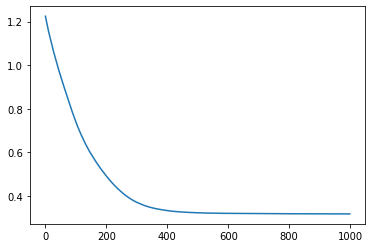


mse: 0.3175


In [28]:
model.compile(optimizer='Adam', loss='mse')
history = model.fit(stdized_data, stdized_data, epochs=1000, verbose=0)
plt.plot(history.history['loss'])
plt.show()
print()
print(f"mse: {history.history['loss'][-1]:.4f}")

In [29]:
components = model.weights[0].numpy()
pd.DataFrame(components.T, index=['component_1', 'component_2'], columns=df.columns[2:])

,Corruption,Peace,Legal,GDP Growth
component_1,-0.532982,0.641718,-0.513805,-0.678542
component_2,0.810494,-0.401774,0.372273,0.004544


In [30]:
new_coordinate = pd.DataFrame(stdized_data @ components, columns=['component_1', 'component_2'], index=df['Country'])
explained_var = new_coordinate.var(0) * len(stdized_data)
explained_var

component_1    389.873608
component_2    266.608283
dtype: float64

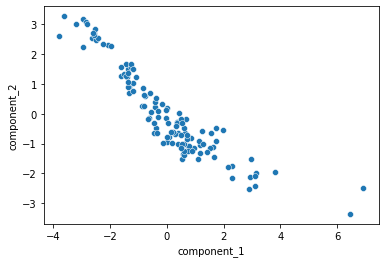

In [31]:
sns.scatterplot(x='component_1', y='component_2', data=new_coordinate)
plt.show()

In [32]:
kmeans_scaled = KMeans(n_clusters=3, random_state=3).fit(stdized_data)
category = {0: "high", 1: "low", 2: "moderate"}
kmeans_scaled_str_labels = np.array(list(map(lambda n: category[n], kmeans_scaled.labels_)))
kmeans_scaled_str_labels[:5]

array(['moderate', 'moderate', 'high', 'moderate', 'low'], dtype='<U8')

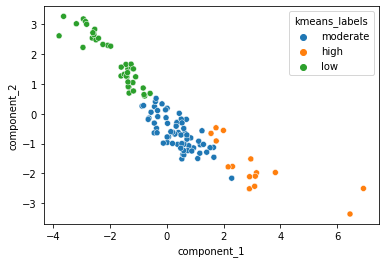

In [33]:
new_coordinate_with_kmeans_labels = new_coordinate.copy()
new_coordinate_with_kmeans_labels.insert(2, 'kmeans_labels', kmeans_scaled_str_labels)
sns.scatterplot(x='component_1', y='component_2', data=new_coordinate_with_kmeans_labels, hue='kmeans_labels')
plt.show()

# CNN

In [34]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images.shape, train_labels.shape

170500096/170498071 [==============================] - 4s 0us/step


((50000, 32, 32, 3), (50000, 1))

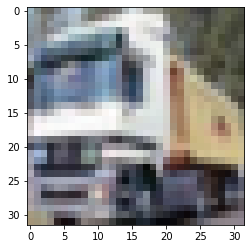

In [35]:
img = train_images[1]
plt.imshow(img)
plt.show()

In [36]:
img = train_images[:2]
img.shape

(2, 32, 32, 3)

In [37]:
inputs = Input(img[0].shape)
outputs = Conv2D(32, (5, 5), activation='linear')(inputs)
model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
Total params: 2,432
Trainable params: 2,432
Non-trainable params: 0
_________________________________________________________________


In [38]:
(5*5*3+1)*32

2432

In [39]:
out = model(img).numpy()

# 自己算的 output
out_ = np.zeros_like(out)

# network 初始化的權重
filter = model.weights[0].numpy()
bias = model.weights[1].numpy()

print(filter.shape, bias.shape, out.shape)

(5, 5, 3, 32) (32,) (2, 28, 28, 32)


In [40]:
w, h = img.shape[1], img.shape[2]  # 32 X 32
fw, fh = filter.shape[:2]  # 5 X 5
n_channels = 32  # 32 feature maps
for n in range(n_channels):
    for i in range(w-fw+1):
        for j in range(h-fh+1):
            out_[:, i, j, n] = (img[:, i:i+fw, j:j+fw, :] * filter[:, :, :, n]).sum((1, 2, 3))
    out_[:, :, :, n] += bias[n]

In [41]:
np.allclose(out, out_, atol=1e-4)

True

In [42]:
max_pool = MaxPool2D()
max_out = max_pool(out)
max_out.shape

TensorShape([2, 14, 14, 32])

In [43]:
# 2 x 2 pool, 2 x 2 stride
# stride: 每次移動幾格，此處設定表示不會有 overlap
pool_sz, stride = 2, 2

# 最後出來的 shape 應該是多少
# 如果是偶數則減半，奇數呢？
# padding=valid: 13 x 13 => 6 x 6 (多出的不管)
max_out_size = int(np.ceil((out_.shape[1]-pool_sz+1)/stride))
max_out_ = np.zeros((2, max_out_size, max_out_size, 32))
for i in range(max_out_size):
    for j in range(max_out_size):
        w_start, h_start = i*stride, j*stride
        max_out_[:, i, j, :] = np.max(out_[:, w_start:w_start+pool_sz, h_start:h_start+pool_sz, :], axis=(1, 2))

In [44]:
np.allclose(max_out, max_out_, atol=1e-4)

True

In [45]:
inputs = Input(img[0].shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPool2D()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10)(x)

model = Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0   

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels), verbose=0)

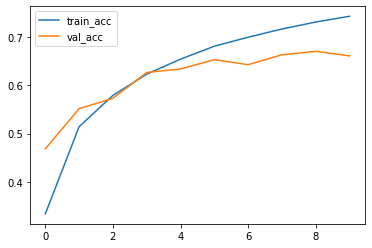

train_acc: 0.7430
val_acc: 0.6610


In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_acc', 'val_acc'])
plt.show()
print(f"train_acc: {history.history['accuracy'][-1]:.4f}")
print(f"val_acc: {history.history['val_accuracy'][-1]:.4f}")

# RNN

In [48]:
# N x T x D
input_seq = tf.random.uniform((3, 10, 5))
inputs = Input(input_seq[0].shape)
y = SimpleRNN(32)(inputs)
model = Model(inputs, y)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 5)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1216      
Total params: 1,216
Trainable params: 1,216
Non-trainable params: 0
_________________________________________________________________


In [49]:
for w in model.weights:
    print(w.shape)
print(5 * 32 + 32 * 32 + 32)

(5, 32)
(32, 32)
(32,)
1216


In [50]:
model(input_seq).shape

TensorShape([3, 32])

In [51]:
# 5x32(feature to hidden), 32x32(hidden to hidden), 32(bias)
xh, hh, b = [w.numpy() for w in model.weights]
hidden_v = np.zeros((3, 32))
# T timestamp
for t in range(input_seq.shape[1]):
    hidden_v = tf.math.tanh(input_seq[:, t, :] @ xh + hidden_v @ hh + b)
print(np.allclose(model(input_seq), hidden_v))

True


一個 sequence 中，先輸入的東西不同，導致 hidden_v 存的東西不同 \\
使得後續 seq 即便輸入不同的值，也會有不同的 output \\
這不像是其他的 NN 那樣把每個輸入之間都視為 independent

# Bidirectional RNN

讀一句子，如果也考慮到從後看到前，效果會更好

In [52]:
# N x T x D
input_seq = tf.random.uniform((3, 10, 5))
inputs = Input(input_seq[0].shape)
y = Bidirectional(SimpleRNN(32))(inputs)
model = Model(inputs, y)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 5)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                2432      
Total params: 2,432
Trainable params: 2,432
Non-trainable params: 0
_________________________________________________________________


In [53]:
# 5x32(feature to hidden), 32x32(hidden to hidden), 32(bias)
xh, hh, b, xh_backward, hh_backward, b_backward = [w.numpy() for w in model.weights]
hidden_v = np.zeros((3, 32))
hidden_v_backward = np.zeros((3, 32))
T = input_seq.shape[1]
# T timestamp
for t in range(input_seq.shape[1]):
    hidden_v = tf.math.tanh(input_seq[:, t, :] @ xh + hidden_v @ hh + b)
    hidden_v_backward = tf.math.tanh(input_seq[:, T-1-t, :] @ xh_backward + hidden_v_backward @ hh_backward + b_backward)
print(np.allclose(model(input_seq), tf.concat([hidden_v, hidden_v_backward], axis=1)))

True


# LSTM

In [54]:
# N x T x D
hidden = 32
input_seq = tf.random.uniform((3, 10, 5))
inputs = Input(input_seq[0].shape)
y = LSTM(hidden)(inputs)
model = Model(inputs, y)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10, 5)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                4864      
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
_________________________________________________________________


In [55]:
xh, hh, b = [w.numpy() for w in model.weights]
hidden_v = np.zeros((3, hidden))
cell = np.zeros((3, hidden))
for t in range(input_seq.shape[1]):
    # 3x5 @ 5x128 + 3x32 @ 32x128 + 128,
    z = input_seq[:, t, :] @ xh + hidden_v @ hh + b
    input_gate = tf.math.sigmoid(z[:,  :hidden])
    forget_gate = tf.math.sigmoid(z[:, hidden:2*hidden])
    input = tf.math.tanh(z[:, 2*hidden:3*hidden])
    output_gate = tf.math.sigmoid(z[:, 3*hidden:4*hidden])
    cell = input * input_gate + cell * forget_gate
    hidden_v = tf.math.tanh(cell) * output_gate
print(np.allclose(model(input_seq), hidden_v))

True
